In [2]:
import numpy as np
from pathlib import Path

from sympy.benchmarks.bench_meijerint import sigma2
from tqdm import tqdm

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import datasets
from PIL import Image
from torchvision.transforms import ToTensor
from models.vae_dataset import VAENpDataset

In [4]:
dataset = VAENpDataset(path_to_np_files="data", img_size=96)

100%|██████████| 7/7 [00:00<00:00, 18.58it/s]


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class VAE(nn.Module):
    def __init__(self, channels, image_siae, hidden_dim=200, z_diz=20):
        super().__init__()
        self.image_size = image_siae
        self.channels = channels
        input_dim = image_siae*image_siae*channels

        self.img_2hid = nn.Linear(input_dim, hidden_dim)
        self.hid_2mu = nn.Linear(hidden_dim, z_diz)
        self.hid_2sigma = nn.Linear(hidden_dim, z_diz)

        self.z_2hid = nn.Linear(z_diz, hidden_dim)
        self.hid_2img = nn.Linear(hidden_dim, input_dim)

        self.relu = nn.ReLU()

    def encode(self, x):
        x = x.flatten(1)
        h = self.relu(self.img_2hid(x))

        mu, sigma = self.hid_2mu(h), self.hid_2sigma(h)

        return mu, sigma
    def decode(self, z):
        h = self.relu(self.z_2hid(z))
        return torch.sigmoid(self.hid_2img(h)).reshape((-1, self.channels, self.image_size, self.image_size))

    def forward(self, x):
        mu, sigma = self.encode(x)
        epsilone = torch.randn_like(sigma)
        z_perametrized = mu +sigma*epsilone
        x_recon = self.decode(z_perametrized)
        return x_recon, mu, sigma


In [13]:
vae = VAE(3, 96, hidden_dim=1024, z_diz=128)

In [17]:
x = dataset[0]

In [23]:
x.unsqueeze(0).flatten(1).shape

torch.Size([1, 27648])

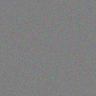

In [9]:
Image.fromarray((vae.forward(x)[0].squeeze(0).detach().numpy().transpose(1,2,0).astype(np.float32)*255).astype(np.uint8))

In [10]:
(vae.forward(x)[0].squeeze(0).detach().numpy().astype(np.float32)*255).astype(np.uint8)

array([[[126, 133, 126, ..., 131, 126, 125],
        [126, 134, 132, ..., 130, 129, 132],
        [123, 129, 131, ..., 132, 133, 128],
        ...,
        [126, 120, 125, ..., 128, 128, 132],
        [124, 135, 132, ..., 130, 123, 135],
        [120, 121, 134, ..., 126, 118, 124]],

       [[123, 127, 129, ..., 133, 126, 120],
        [126, 128, 121, ..., 135, 126, 130],
        [129, 132, 130, ..., 124, 124, 132],
        ...,
        [129, 126, 136, ..., 126, 128, 122],
        [128, 125, 127, ..., 121, 129, 126],
        [126, 128, 119, ..., 122, 118, 131]],

       [[123, 125, 124, ..., 125, 127, 129],
        [131, 129, 132, ..., 130, 119, 120],
        [131, 124, 128, ..., 126, 126, 122],
        ...,
        [129, 125, 120, ..., 126, 126, 119],
        [131, 128, 122, ..., 128, 125, 128],
        [128, 128, 127, ..., 122, 126, 131]]],
      shape=(3, 96, 96), dtype=uint8)

In [14]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [15]:
from torch import optim

In [16]:
optimizer = optim.Adam(vae.parameters(), lr=0.003)

In [17]:
loss_fn = nn.BCELoss(reduction='sum')

In [18]:
for epoch in range(100):
    loop = tqdm(enumerate(dataloader))
    for i, x in loop:
        x_recon, mu, sigma = vae(x)

        rec_loss = loss_fn(x_recon, x)
        kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

        loss = rec_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())

1750it [03:42,  7.85it/s, loss=2.5e+5] 
53it [00:07,  6.96it/s, loss=2.51e+5]


KeyboardInterrupt: 

In [20]:
x = dataset[0].unsqueeze(0)

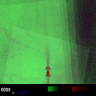

In [21]:
Image.fromarray((vae.forward(x)[0].squeeze(0).detach().numpy().transpose(1,2,0).astype(np.float32)*255).astype(np.uint8))

In [22]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image

In [23]:
def create_vae_animation(npz_path, vae_model, save_path="vae_reconstruction.gif", num_frames=100):
    """
    npz_path: путь к файлу с данными (предполагаем ключ 'obs')
    vae_model: ваша загруженная модель (torch.nn.Module)
    save_path: куда сохранить гифку
    num_frames: сколько кадров анимировать
    """

    # 1. Загрузка данных
    print(f"Загрузка данных из {npz_path}...")
    data = np.load(npz_path)

    # Предполагаем, что картинки лежат по ключу 'obs' или 'observations'
    # Если у вас другой ключ, поменяйте его здесь
    key = 'obs' if 'obs' in data else list(data.keys())[0]
    observations = data[key] # Ожидаем форму (N, 96, 96, 3) или (N, 64, 64, 3)

    # 2. Подготовка модели
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae_model.to(device)
    vae_model.eval() # Переключаем в режим оценки (выключает dropout и т.д.)

    # 3. Настройка графика
    fig, ax = plt.subplots()
    ax.axis('off') # Убираем оси координат

    # Инициализация пустой картинки
    # Берем первый кадр просто чтобы узнать размер
    img_plot = ax.imshow(observations[0])

    print("Генерация анимации...")

    def update(frame_idx):
        # --- ПРЕПРОЦЕССИНГ ---
        # Берем кадр из датасета. Он сейчас (H, W, C) и 0-255 uint8
        raw_frame = observations[frame_idx]

        # Конвертируем в формат PyTorch: (1, C, H, W) и нормализуем 0-1
        # permute(2, 0, 1) делает из HWC -> CHW
        input_tensor = torch.from_numpy(raw_frame).permute(2, 0, 1).float() / 255.0

        # Добавляем Batch dimension -> (1, C, H, W)
        x = input_tensor.unsqueeze(0).to(device)

        # --- ВАШ КОД + ИНФЕРЕНС ---
        with torch.no_grad(): # Отключаем градиенты для скорости
            # ВАШ СНИППЕТ ВСТАВЛЕН СЮДА
            # x подается в VAE, на выходе реконструированная картинка

            # Примечание: Ваш сниппет возвращает PIL Image.
            # Matplotlib хочет numpy array. Поэтому оборачиваем в np.array()
            reconstructed_pil = Image.fromarray(
                (vae_model(x)[0].squeeze(0).cpu().detach().numpy().transpose(1,2,0).astype(np.float32)*255).astype(np.uint8)
            )

            reconstructed_img = np.array(reconstructed_pil)

        # Обновляем картинку на графике
        img_plot.set_data(reconstructed_img)
        ax.set_title(f"Frame: {frame_idx}")
        return [img_plot]

    # Создание анимации
    # frames=num_frames ограничивает длину, чтобы не рендерить весь датасет часами
    ani = FuncAnimation(fig, update, frames=range(num_frames), blit=True)

    # Сохранение
    print(f"Сохранение в {save_path}...")
    ani.save(save_path, fps=30, writer='pillow') # 'pillow' сохраняет gif
    print("Готово!")
    plt.close()

In [24]:
path_to_npz = "data/car_racing_data_ep_2.npz" # Или "data_1.npz"

# 2. Здесь должна быть инициализация вашей модели

# ПРОВЕРКА: Если модели нет под рукой, код упадет.
    # Раскомментируйте строку ниже для запуска функции, если vae уже определен в вашем коде
create_vae_animation(path_to_npz, vae)

Загрузка данных из data/car_racing_data_ep_2.npz...
Генерация анимации...
Сохранение в vae_reconstruction.gif...
Готово!
